use TPU (so we don't see CUDA out of memory)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os

MODEL_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/model/"
# MODEL_DIR = "/content/gdrive/MyDrive/Nella/CLIP/model/"
DATA_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/data/"
# DATA_DIR = "/content/gdrive/MyDrive/Nella/CLIP/data/"

FASHION_MINI_DIR = os.path.join(DATA_DIR, "indo_fashion_mini/")

CLIP_FASHION_PATH = os.path.join(MODEL_DIR, "CLIP_fashion")
BEST_PATH = CLIP_FASHION_PATH.replace("CLIP_fashion", "CLIP_fashion_best")

In [7]:
BEST_PATH2 = BEST_PATH + "2"
BEST_PATH3 = BEST_PATH + "3"

In [4]:
from transformers import CLIPProcessor, VisionTextDualEncoderModel, AutoTokenizer, BertTokenizer

model_base = VisionTextDualEncoderModel.from_pretrained("Galuh/clip-indonesian", from_flax=True)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-large-p2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

You are using a model of type hybrid-clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.


flax_model.msgpack:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_flax_pytorch_utils.py:460: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  pt_model_dict[flax_key] = torch.from_numpy(flax_tensor)
All Flax model weights were used when initializing VisionTextDualEncoderModel.

All the weights of VisionTextDualEncoderModel were initialized from the Flax model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionTextDualEncoderModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Fine Tuning

In [8]:
import pandas as pd

train_df = pd.read_csv(os.path.join(FASHION_MINI_DIR,"train.csv"))


# Verify the sizes of the resulting splits
print("Train size:", len(train_df))

Train size: 15000


In [9]:
train_df = train_df[["image_path", "ID_product_title", "ID_class_label"]]
train_df = train_df.dropna()

if we want to limit the data

In [10]:
# # List to store the train, validation, and test DataFrames for each class
# train_dfs = []

# # Iterate over each class in the DataFrame
# for class_label in train_df['ID_class_label'].unique():  # Replace 'class_column' with the actual column name containing class labels
#     # Select data for the current class
#     class_df = train_df[train_df['ID_class_label'] == class_label]  # Replace 'class_column' with the actual column name containing class labels
#     train = class_df.iloc[:300]
#     train_dfs.append(train)

# # Concatenate DataFrames for each class to get the final train, validation, and test sets
# train_df = pd.concat(train_dfs)

# # Optional: Shuffle the train, validation, and test sets
# train_df = train_df.sample(frac=1, random_state=42)

# # Verify the sizes of the resulting splits
# print("Train size:", len(train_df))

Train size: 4500


In [11]:
column_names = ["image_path", "ID_product_title", "ID_class_label"]
# Check if there are any NaN values in the column
for column_name in column_names:
  if train_df[column_name].isna().any():
      print(f"There are NaN values in column '{column_name}'.")
  else:
      print(f"No NaN values found in column '{column_name}'.")

No NaN values found in column 'image_path'.
No NaN values found in column 'ID_product_title'.
No NaN values found in column 'ID_class_label'.


In [12]:
train_df["ID_class_label"].value_counts()

palazzo               300
gaun                  300
dupatta               300
pria_kurta            300
sari                  300
celana_dhoti          300
wanita_mojaris        300
sherwani              300
lehenga               300
blus                  300
legging_dan_salwar    300
pria_mojaris          300
rok_dalam             300
jaket_nehru           300
wanita_kurta          300
Name: ID_class_label, dtype: int64

In [13]:
train_image_path_list = train_df["image_path"].apply(lambda x: os.path.join(FASHION_MINI_DIR, x)).tolist()
train_caption_list = train_df["ID_product_title"].tolist()

In [ ]:
# # check if any image that is not found
# found_indices = []
# for idx, path in enumerate(train_image_path_list):
#   if os.path.exists(path):
#     found_indices.append(idx)

In [ ]:
len(train_image_path_list), len(train_caption_list) #, len(found_indices)

(4500, 4500)

In [ ]:
train_caption_list[0]

'Celana Campuran Khaki Rayon Crepe Wanita Berkobar'

## Experiment

In [14]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
from torchvision import transforms

BATCH_SIZE = 8  # Adjust batch size as needed

transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to tensors
])

MAX_LEN_TEXT = 512

In [ ]:
# https://medium.com/aimonks/a-guide-to-fine-tuning-clip-models-with-custom-data-6c7c0d1416fb

In [ ]:
# processor.tokenizer(["babi merah", "BABI MERAH"], truncation=True, max_length=MAX_LEN_TEXT, pad_to_max_length=True, return_tensors="pt")

In [16]:
from PIL import Image

class ImageTitleDataset():
    def __init__(self, list_image_path, list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        # self.title  = clip.tokenize(list_txt)
        # self.title = processor.tokenizer(list_txt, truncation=True, padding=True, max_length=MAX_LEN_TEXT, return_tensors="pt")["input_ids"]
        self.title = processor.tokenizer(list_txt, truncation=True, padding=True, max_length=MAX_LEN_TEXT, return_tensors="pt")
        # print(self.title.shape)
        self.title = dict(self.title)
        for key, value in self.title.items():
          # ["input_ids", "token_type_ids", "attention_mask"]
          self.title[key] = torch.as_tensor(self.title[key])
        # self.title = torch.as_tensor(self.title)
        self.newsize = (224, 224)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = Image.open(self.image_path[idx])
        image = image.resize(self.newsize)
        # shape: torch.Size([3, 224, 224])
        # image = transform(image)
        # shape: torch.Size([1, 3, 224, 224]) -> torch.Size([3, 224, 224])
        image = processor.image_processor(image, return_tensors="pt").pixel_values.squeeze(0)
        # assert len(image.shape) == 3 and tuple(image.shape[1:]) == self.newsize
        text = self.title["input_ids"][idx]
        attention_mask = self.title["attention_mask"][idx]

        return image, text, attention_mask

In [17]:
# image = Image.open(train_image_path_list[0]).resize((224,224))
# print(transform(image).shape)
# image = processor.image_processor(image, return_tensors="pt").pixel_values
# print(image.shape, image.squeeze(0).shape)

In [18]:
train_caption_list[:5]

['Celana Campuran Khaki Rayon Crepe Wanita Berkobar',
 'Setelan Anarkali Salwar Bordir Semi Jahitan Maroon Faux Georgette Wanita (Ukuran Bebas)',
 'Dupatta Banarasi Motif Katun Wanita',
 'Dupatta Banarasi Sutra Wanita',
 'Kurta Katun Pria Saja']

In [19]:
train_df["ID_class_label"].unique()

array(['palazzo', 'gaun', 'dupatta', 'pria_kurta', 'sari', 'celana_dhoti',
       'wanita_mojaris', 'sherwani', 'lehenga', 'blus',
       'legging_dan_salwar', 'pria_mojaris', 'rok_dalam', 'jaket_nehru',
       'wanita_kurta'], dtype=object)

In [24]:
# https://stackoverflow.com/questions/63517293/valueerror-textencodeinput-must-be-uniontextinputsequence-tupleinputsequence/63870843#63870843
from torch.utils.data import DataLoader

train_dataset = ImageTitleDataset(train_image_path_list, train_caption_list)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
# test if the dataloader can be accessed (should be raised error)
for image, text, attention_mask in train_dataloader:
  # print(image)
  break

### Without ReduceLROnPlateau

In [ ]:
# https://www.kaggle.com/code/zacchaeus/clip-finetune
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [ ]:
model_pt = VisionTextDualEncoderModel.from_pretrained("Galuh/clip-indonesian", from_flax=True)
if torch.cuda.is_available():
    model_pt.cuda()

You are using a model of type hybrid-clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.
All Flax model weights were used when initializing VisionTextDualEncoderModel.

All the weights of VisionTextDualEncoderModel were initialized from the Flax model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionTextDualEncoderModel for predictions without further training.


In [ ]:
from tqdm import tqdm
from torch import nn

# parameter: https://github.com/openai/CLIP/issues/362
# optimizer = torch.optim.Adam(model_pt.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = torch.optim.Adam(model_pt.parameters())
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

num_epochs = 30
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts,attention_mask = batch

        images= images.to(device)
        texts = texts.to(device)
        attention_mask = attention_mask.to(device)

        # print(images.shape)
        # print("==============================")
        # print(texts.shape)

        # Forward pass
        # logits_per_image, logits_per_text = model_pt(texts, images,attention_mask)
        outputs = model_pt(input_ids=texts, attention_mask=attention_mask, \
                          pixel_values=images, return_loss=True)
        # print(dir(outputs))
        # loss, logits_per_image = outputs.loss, outputs.logits_per_image
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else :
            # convert_models_to_fp32(model_pt)
            optimizer.step()
            # clip.model.convert_weights(model_pt)
            # convert_weights(model_pt)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

Epoch 29/30, Loss: 2.0794: 100%|██████████| 375/375 [02:22<00:00,  2.63it/s]


In [ ]:
# Save the model to the specified path
model_pt.save_pretrained(BEST_PATH2)

### With ReduceLROnPlateau

In [21]:
model_pt = VisionTextDualEncoderModel.from_pretrained("Galuh/clip-indonesian", from_flax=True)
if torch.cuda.is_available():
    model_pt.cuda()

BEST_PATH = CLIP_FASHION_PATH.replace("CLIP_fashion", "CLIP_fashion_best")

You are using a model of type hybrid-clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.
All Flax model weights were used when initializing VisionTextDualEncoderModel.

All the weights of VisionTextDualEncoderModel were initialized from the Flax model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionTextDualEncoderModel for predictions without further training.


In [ ]:
from torch.nn.utils import clip_grad_norm_
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define learning rate scheduler
# optimizer = torch.optim.Adam(model_pt.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
# optimizer = torch.optim.SGD(model_pt.parameters(), lr=0.01, momentum=(0.9, 0.98), weight_decay=0.2)
optimizer = torch.optim.AdamW(model_pt.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

max_grad_norm = 1.0  # Define the maximum gradient norm

num_epochs = 30
best_loss = float('inf')

for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images, texts, attention_mask = batch
        # print(images.shape)
        # print(texts.shape)
        images = images.to(device)
        texts = texts.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model_pt(input_ids=texts, attention_mask=attention_mask, pixel_values=images, return_loss=True)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

        total_loss.backward()

        # Clip gradients to prevent them from exceeding the maximum gradient norm
        clip_grad_norm_(model_pt.parameters(), max_grad_norm)

        optimizer.step()

        running_loss += total_loss.item()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item():.4f}")

    # Update learning rate
    scheduler.step(running_loss)

    # Print average loss for epoch
    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Check if current epoch has the best loss so far
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        # Save the model if it has the best loss
        model_pt.save_pretrained(BEST_PATH3)
# 2.0794

Epoch 1/30, Loss: 1.1717: 100%|██████████| 1875/1875 [3:19:42<00:00,  6.39s/it]


Epoch [1/30], Loss: 1.1271


Epoch 2/30, Loss: 1.2118: 100%|██████████| 1875/1875 [21:30<00:00,  1.45it/s]


Epoch [2/30], Loss: 0.9886


Epoch 3/30, Loss: 1.0760: 100%|██████████| 1875/1875 [21:35<00:00,  1.45it/s]


Epoch [3/30], Loss: 0.9134


Epoch 4/30, Loss: 2.0794: 100%|██████████| 1875/1875 [21:32<00:00,  1.45it/s]


Epoch [4/30], Loss: 1.5898


Epoch 5/30, Loss: 2.0794: 100%|██████████| 1875/1875 [21:26<00:00,  1.46it/s]


Epoch [5/30], Loss: 2.0795


Epoch 6/30, Loss: 2.0794: 100%|██████████| 1875/1875 [21:24<00:00,  1.46it/s]


Epoch [6/30], Loss: 2.0794


Epoch 7/30, Loss: 2.1953: 100%|██████████| 1875/1875 [21:23<00:00,  1.46it/s]


Epoch 00007: reducing learning rate of group 0 to 5.0000e-06.
Epoch [7/30], Loss: 2.0795


Epoch 8/30, Loss: 1.6785: 100%|██████████| 1875/1875 [21:25<00:00,  1.46it/s]


Epoch [8/30], Loss: 1.8510


Epoch 9/30, Loss: 1.4886: 100%|██████████| 1875/1875 [21:26<00:00,  1.46it/s]


Epoch [9/30], Loss: 1.7263


Epoch 10/30, Loss: 1.1381: 100%|██████████| 1875/1875 [21:26<00:00,  1.46it/s]


Epoch [10/30], Loss: 1.3661


Epoch 11/30, Loss: 1.2867: 100%|██████████| 1875/1875 [21:28<00:00,  1.45it/s]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-07.
Epoch [11/30], Loss: 1.0493


Epoch 12/30, Loss: 0.5068: 100%|██████████| 1875/1875 [21:28<00:00,  1.45it/s]


Epoch [12/30], Loss: 0.9017


Epoch 13/30, Loss: 0.6111: 100%|██████████| 1875/1875 [21:28<00:00,  1.46it/s]


Epoch [13/30], Loss: 0.8701


Epoch 14/30, Loss: 0.7437: 100%|██████████| 1875/1875 [21:27<00:00,  1.46it/s]


Epoch [14/30], Loss: 0.8432


Epoch 15/30, Loss: 0.8281: 100%|██████████| 1875/1875 [21:29<00:00,  1.45it/s]


Epoch [15/30], Loss: 0.8346


Epoch 16/30, Loss: 1.0684: 100%|██████████| 1875/1875 [21:27<00:00,  1.46it/s]


Epoch [16/30], Loss: 0.8137


Epoch 17/30, Loss: 0.8754: 100%|██████████| 1875/1875 [21:27<00:00,  1.46it/s]


Epoch [17/30], Loss: 0.8139


Epoch 18/30, Loss: 0.7164: 100%|██████████| 1875/1875 [21:30<00:00,  1.45it/s]


Epoch [18/30], Loss: 0.7958


Epoch 19/30, Loss: 0.6454: 100%|██████████| 1875/1875 [21:31<00:00,  1.45it/s]


Epoch [19/30], Loss: 0.7847


Epoch 20/30, Loss: 0.6699: 100%|██████████| 1875/1875 [21:29<00:00,  1.45it/s]


Epoch [20/30], Loss: 0.7751


Epoch 21/30, Loss: 0.8702: 100%|██████████| 1875/1875 [21:29<00:00,  1.45it/s]


Epoch [21/30], Loss: 0.7586


Epoch 22/30, Loss: 0.7141: 100%|██████████| 1875/1875 [21:27<00:00,  1.46it/s]


Epoch [22/30], Loss: 0.7496


Epoch 23/30, Loss: 0.4406: 100%|██████████| 1875/1875 [21:29<00:00,  1.45it/s]


Epoch [23/30], Loss: 0.7442


Epoch 24/30, Loss: 0.7007: 100%|██████████| 1875/1875 [21:29<00:00,  1.45it/s]


Epoch [24/30], Loss: 0.7285


Epoch 25/30, Loss: 0.5956: 100%|██████████| 1875/1875 [21:30<00:00,  1.45it/s]


Epoch [25/30], Loss: 0.7317


Epoch 26/30, Loss: 0.8816: 100%|██████████| 1875/1875 [21:29<00:00,  1.45it/s]


Epoch [26/30], Loss: 0.7213


Epoch 27/30, Loss: 0.5519: 100%|██████████| 1875/1875 [21:31<00:00,  1.45it/s]


Epoch [27/30], Loss: 0.7146


Epoch 28/30, Loss: 0.9014: 100%|██████████| 1875/1875 [21:31<00:00,  1.45it/s]


Epoch [28/30], Loss: 0.7034


Epoch 29/30, Loss: 1.0939: 100%|██████████| 1875/1875 [21:33<00:00,  1.45it/s]


Epoch [29/30], Loss: 0.7003


Epoch 30/30, Loss: 0.7199: 100%|██████████| 1875/1875 [21:31<00:00,  1.45it/s]


Epoch [30/30], Loss: 0.6896


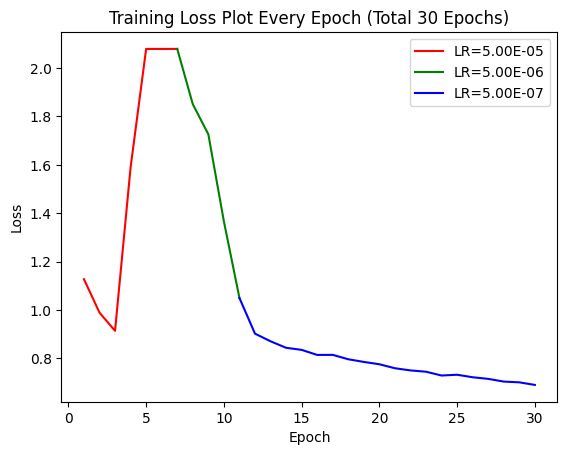

In [ ]:
import matplotlib.pyplot as plt

# Your data
data = [
    1.1271, 0.9886, 0.9134, 1.5898, 2.0795, 2.0794, 2.0795, 1.851, 1.7263, 1.3661,
    1.0493, 0.9017, 0.8701, 0.8432, 0.8346, 0.8137, 0.8139, 0.7958, 0.7847, 0.7751,
    0.7586, 0.7496, 0.7442, 0.7285, 0.7317, 0.7213, 0.7146, 0.7034, 0.7003, 0.6896
]

# Divide the data into three groups based on index
group1 = data[:7] # 0-6 (the first 7 epochs)
group2 = data[6:11] # then 4 epochs after that)
group3 = data[10:]

# Plot the data with different colors
plt.plot(range(1, 8), group1, color='red', label='LR=5.00E-05')
plt.plot(range(7, 12), group2, color='green', label='LR=5.00E-06')
plt.plot(range(11, 31), group3, color='blue', label='LR=5.00E-07')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Plot Every Epoch (Total 30 Epochs)')
plt.legend()

# Show the plot
plt.show()

In [26]:
model_pt = VisionTextDualEncoderModel.from_pretrained("Galuh/clip-indonesian", from_flax=True)
if torch.cuda.is_available():
    model_pt.cuda()

You are using a model of type hybrid-clip to instantiate a model of type vision-text-dual-encoder. This is not supported for all configurations of models and can yield errors.
All Flax model weights were used when initializing VisionTextDualEncoderModel.

All the weights of VisionTextDualEncoderModel were initialized from the Flax model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionTextDualEncoderModel for predictions without further training.
